In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-08 00:20:31--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.40.32, 52.216.60.120, 52.217.135.192, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.40.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  62.0MB/s    in 0.2s    

2024-04-08 00:20:31 (62.0 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Analyzing the data from the Jena weather dataset**


In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()

lines_data_data = data.split("\n")
header = lines_data_data[0].split(",")
lines_data_data= lines_data_data[1:]
print(header)
print(len(lines_data_data))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Examining the data**

In [ ]:
!pip install numpy

In [ ]:
import numpy as np

In [ ]:
temperature = np.zeros((len(lines_data_data),))
raw_data = np.zeros((len(lines_data_data), len(header) - 1))
for i, line in enumerate(lines_data_data):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Charting the temperature time series**

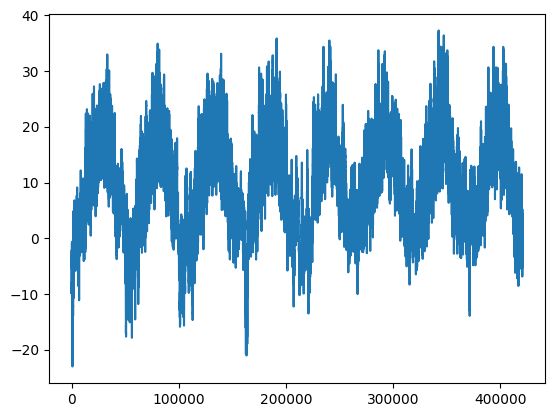

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first ten days' worth of temperature data**

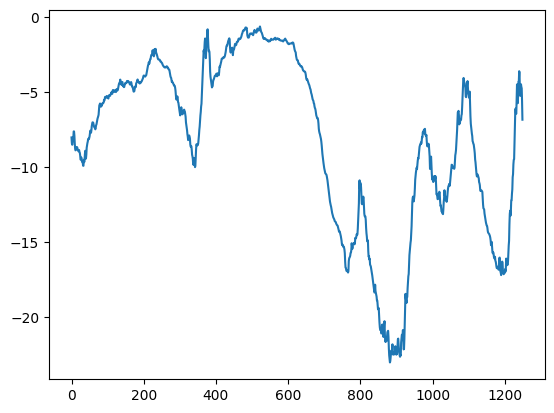

In [ ]:
plt.plot(range(1250), temperature[:1250])


**Figuring out how many samples each data split will use**

In [ ]:
num_training_samples = int(0.2 * len(raw_data))
num_validation_samples = int(0.15 * len(raw_data))
num_test_samples = len(raw_data) - num_training_samples - num_validation_samples
print("num_training_samples:", num_training_samples)
print("num_validation_samples:", num_validation_samples)
print("num_test_samples:", num_test_samples)


num_training_samples: 84090
num_validation_samples: 63067
num_test_samples: 273294


**Getting the Data Ready**

Data Normalization

In [ ]:
mean = raw_data[:num_training_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_training_samples].std(axis=0)
raw_data /= std
import numpy as np
from tensorflow import keras
initial_sequence = np.arange(10)
dummy_data = keras.utils.timeseries_dataset_from_array(
data=initial_sequence[:-2],
targets=initial_sequence[2:],
sequence_length=4,
batch_size=1,
)
for inputs, targets in dummy_data:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2, 3] 2
[1, 2, 3, 4] 3
[2, 3, 4, 5] 4
[3, 4, 5, 6] 5
[4, 5, 6, 7] 6


**Real-time dataset development for training, validation, and testing**

In [ ]:
sampling_rate = 4
sequence_length = 80
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 128

training_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=0,
end_index=num_training_samples)

validation_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=num_training_samples,
end_index=num_training_samples + num_validation_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=num_training_samples + num_validation_samples)

**Analyzing one of our datasets' outputs**

In [ ]:
for samples, targets in training_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break


samples shape: (128, 80, 14)
targets shape: (128,)


**A sensible, non-machine-learning baseline**

Figuring out the appropriate baseline MAE.


In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(validation_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")


Validation MAE: 4.53
Test MAE: 4.08


**Now let's try a basic machine-learning model.**

**Making use of a tightly connected model via training and assessment**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_dense.x",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=10,
validation_data=validation_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
655/655 [==============================] - 25s 37ms/step - loss: 10.9996 - mae: 2.5362 - val_loss: 9.7963 - val_mae: 2.4595
Epoch 2/10
655/655 [==============================] - 22s 33ms/step - loss: 7.1204 - mae: 2.0988 - val_loss: 11.1368 - val_mae: 2.6104
Epoch 3/10
655/655 [==============================] - 22s 33ms/step - loss: 6.5681 - mae: 2.0185 - val_loss: 9.8181 - val_mae: 2.4730
Epoch 4/10
655/655 [==============================] - 20s 31ms/step - loss: 6.1989 - mae: 1.9635 - val_loss: 10.0079 - val_mae: 2.5162
Epoch 5/10
655/655 [==============================] - 23s 35ms/step - loss: 5.9794 - mae: 1.9255 - val_loss: 9.9696 - val_mae: 2.5205
Epoch 6/10
655/655 [==============================] - 22s 34ms/step - loss: 5.7842 - mae: 1.8964 - val_loss: 9.9886 - val_mae: 2.5122
Epoch 7/10
655/655 [==============================] - 23s 36ms/step - loss: 5.5875 - mae: 1.8619 - val_loss: 10.5185 - val_mae: 2.5911
Epoch 8/10
655/655 [==============================] - 22s 

**Charting the outcomes**

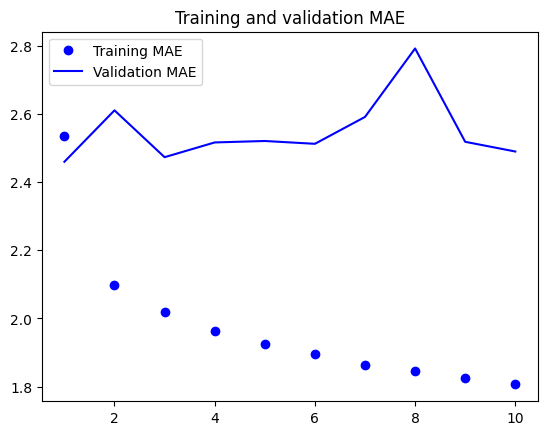

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
validation_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, validation_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


**Trying to implement a 1D convolutional model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_conv.x",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=10,
validation_data=validation_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_conv.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
655/655 [==============================] - 33s 48ms/step - loss: 14.9357 - mae: 2.9048 - val_loss: 13.0086 - val_mae: 2.8757
Epoch 2/10
655/655 [==============================] - 30s 46ms/step - loss: 8.9004 - mae: 2.3369 - val_loss: 12.3432 - val_mae: 2.7979
Epoch 3/10
655/655 [==============================] - 32s 49ms/step - loss: 8.2691 - mae: 2.2573 - val_loss: 10.5341 - val_mae: 2.5453
Epoch 4/10
655/655 [==============================] - 29s 45ms/step - loss: 7.8377 - mae: 2.2007 - val_loss: 12.8243 - val_mae: 2.7744
Epoch 5/10
655/655 [==============================] - 31s 47ms/step - loss: 7.5284 - mae: 2.1604 - val_loss: 10.7644 - val_mae: 2.5869
Epoch 6/10
655/655 [==============================] - 29s 43ms/step - loss: 7.3137 - mae: 2.1303 - val_loss: 10.8477 - val_mae: 2.5912
Epoch 7/10
655/655 [==============================] - 29s 45ms/step - loss: 7.0804 - mae: 2.0967 - val_loss: 11.4199 - val_mae: 2.6766
Epoch 8/10
655/655 [==============================] - 

**An initial recurring baseline**

**A basic model based on LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_lstm.x",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=10,
validation_data=validation_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
655/655 [==============================] - 54s 80ms/step - loss: 47.9305 - mae: 5.0475 - val_loss: 16.3395 - val_mae: 3.1460
Epoch 2/10
655/655 [==============================] - 57s 87ms/step - loss: 11.1033 - mae: 2.5227 - val_loss: 11.6036 - val_mae: 2.6965
Epoch 3/10
655/655 [==============================] - 54s 83ms/step - loss: 7.9006 - mae: 2.1765 - val_loss: 11.6779 - val_mae: 2.6956
Epoch 4/10
655/655 [==============================] - 49s 74ms/step - loss: 7.1674 - mae: 2.0769 - val_loss: 11.7308 - val_mae: 2.6777
Epoch 5/10
655/655 [==============================] - 53s 81ms/step - loss: 6.7103 - mae: 2.0114 - val_loss: 11.7604 - val_mae: 2.6751
Epoch 6/10
655/655 [==============================] - 55s 84ms/step - loss: 6.4247 - mae: 1.9696 - val_loss: 12.3516 - val_mae: 2.7652
Epoch 7/10
655/655 [==============================] - 54s 82ms/step - loss: 6.1402 - mae: 1.9267 - val_loss: 12.0681 - val_mae: 2.7111
Epoch 8/10
655/655 [==============================] -

**Recurrent neural network detection**

**A NumPy RNN implementation**

In [ ]:
import numpy as np
timesteps = 50
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

**One of the recurrent layers of Keras**

**An RNN layer that can handle sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)


**An RNN layer that only provides the most recent output step**

In [ ]:
num_features = 14
steps = 80
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)


(None, 16)


**A layer of RNN that provides the complete output sequence**

In [ ]:
num_features = 14
steps = 80
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)


(None, 80, 16)


**Layer stacking for RNNs**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

**Recurrent neural networks are being used substantially**

**Managing overfitting when there are frequent dropouts**

**A dropout-regularized long short-term memory (LSTM) is trained and tested.**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.15)(inputs)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_lstm_dropout.x",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=30,
validation_data=validation_dataset,
callbacks=callbacks)


Epoch 1/30
655/655 [==============================] - 88s 129ms/step - loss: 53.4162 - mae: 5.4076 - val_loss: 16.9976 - val_mae: 3.1557
Epoch 2/30
655/655 [==============================] - 85s 130ms/step - loss: 16.4169 - mae: 3.0764 - val_loss: 11.0762 - val_mae: 2.6024
Epoch 3/30
655/655 [==============================] - 88s 135ms/step - loss: 13.4412 - mae: 2.8229 - val_loss: 10.5933 - val_mae: 2.5657
Epoch 4/30
655/655 [==============================] - 77s 117ms/step - loss: 12.6540 - mae: 2.7362 - val_loss: 11.2754 - val_mae: 2.6792
Epoch 5/30
655/655 [==============================] - 77s 118ms/step - loss: 12.1032 - mae: 2.6755 - val_loss: 10.6172 - val_mae: 2.5744
Epoch 6/30
655/655 [==============================] - 79s 120ms/step - loss: 11.6627 - mae: 2.6279 - val_loss: 10.4556 - val_mae: 2.5516
Epoch 7/30
655/655 [==============================] - 83s 127ms/step - loss: 11.4099 - mae: 2.6005 - val_loss: 10.2848 - val_mae: 2.5137
Epoch 8/30
655/655 [=====================

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(16, recurrent_dropout=0.1, unroll=True)(inputs)

**recurrent layer stacking**

**A stacked GRU model with dropout regularization: training and evaluation**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = layers.GRU(16, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.2 )(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.x",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=30,
validation_data=validation_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30
655/655 [==============================] - 130s 191ms/step - loss: 50.2425 - mae: 5.1498 - val_loss: 16.3901 - val_mae: 3.0714
Epoch 2/30
655/655 [==============================] - 121s 185ms/step - loss: 14.1372 - mae: 2.8538 - val_loss: 10.2069 - val_mae: 2.4926
Epoch 3/30
655/655 [==============================] - 124s 190ms/step - loss: 11.0781 - mae: 2.5852 - val_loss: 10.1468 - val_mae: 2.4904
Epoch 4/30
655/655 [==============================] - 122s 185ms/step - loss: 10.3729 - mae: 2.5105 - val_loss: 9.9766 - val_mae: 2.4647
Epoch 5/30
655/655 [==============================] - 124s 189ms/step - loss: 9.9669 - mae: 2.4616 - val_loss: 9.9710 - val_mae: 2.4610
Epoch 6/30
655/655 [==============================] - 117s 178ms/step - loss: 9.6120 - mae: 2.4180 - val_loss: 10.5722 - val_mae: 2.5430
Epoch 7/30
655/655 [==============================] - 126s 192ms/step - loss: 9.3242 - mae: 2.3874 - val_loss: 9.9414 - val_mae: 2.4683
Epoch 8/30
655/655 [====================

**RNNs are being used both ways**

**Bidirectional LSTM training and assessment**

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(8))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=10,
validation_data=validation_dataset)


Epoch 1/10
655/655 [==============================] - 69s 99ms/step - loss: 57.0416 - mae: 5.6392 - val_loss: 21.5406 - val_mae: 3.6188
Epoch 2/10
655/655 [==============================] - 65s 99ms/step - loss: 14.4371 - mae: 2.8867 - val_loss: 14.7941 - val_mae: 3.0350
Epoch 3/10
655/655 [==============================] - 59s 90ms/step - loss: 10.2211 - mae: 2.4618 - val_loss: 13.9375 - val_mae: 2.9076
Epoch 4/10
655/655 [==============================] - 61s 92ms/step - loss: 8.7541 - mae: 2.2890 - val_loss: 13.0541 - val_mae: 2.8359
Epoch 5/10
655/655 [==============================] - 60s 92ms/step - loss: 7.9068 - mae: 2.1806 - val_loss: 12.6308 - val_mae: 2.7874
Epoch 6/10
655/655 [==============================] - 61s 93ms/step - loss: 7.4195 - mae: 2.1136 - val_loss: 12.8665 - val_mae: 2.8082
Epoch 7/10
655/655 [==============================] - 65s 100ms/step - loss: 7.0592 - mae: 2.0609 - val_loss: 12.6375 - val_mae: 2.7913
Epoch 8/10
655/655 [==============================]